In [6]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-07-03   AAPL  191.443298  192.460007  193.880005  191.759995   
1         2023-07-03   GOOG  120.422958  120.559998  121.019997  119.705002   
2         2023-07-03   MSFT  335.366516  337.989990  340.899994  336.570007   
3         2023-07-03   NFLX  441.440002  441.440002  441.549988  431.619995   
4         2023-07-03   TSLA  279.820007  279.820007  284.250000  275.109985   

Attribute        Open       Volume  
0          193.779999   31458200.0  
1          120.320000   13888300.0  
2          339.190002   12508700.0  
3          439.760010    3733200.0  
4          276.489990  119685900.0  


In [7]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-07-03   AAPL  191.443298  192.460007  193.880005  191.759995  193.779999   
2023-07-03   GOOG  120.422958  120.559998  121.019997  119.705002  120.320000   
2023-07-03   MSFT  335.366516  337.989990  340.899994  336.570007  339.190002   
2023-07-03   NFLX  441.440002  441.440002  441.549988  431.619995  439.760010   
2023-07-03   TSLA  279.820007  279.820007  284.250000  275.109985  276.489990   

Attribute        Volume  
Date                     
2023-07-03   31458200.0  
2023-07-03   13888300.0  
2023-07-03   12508700.0  
2023-07-03    3733200.0  
2023-07-03  119685900.0  


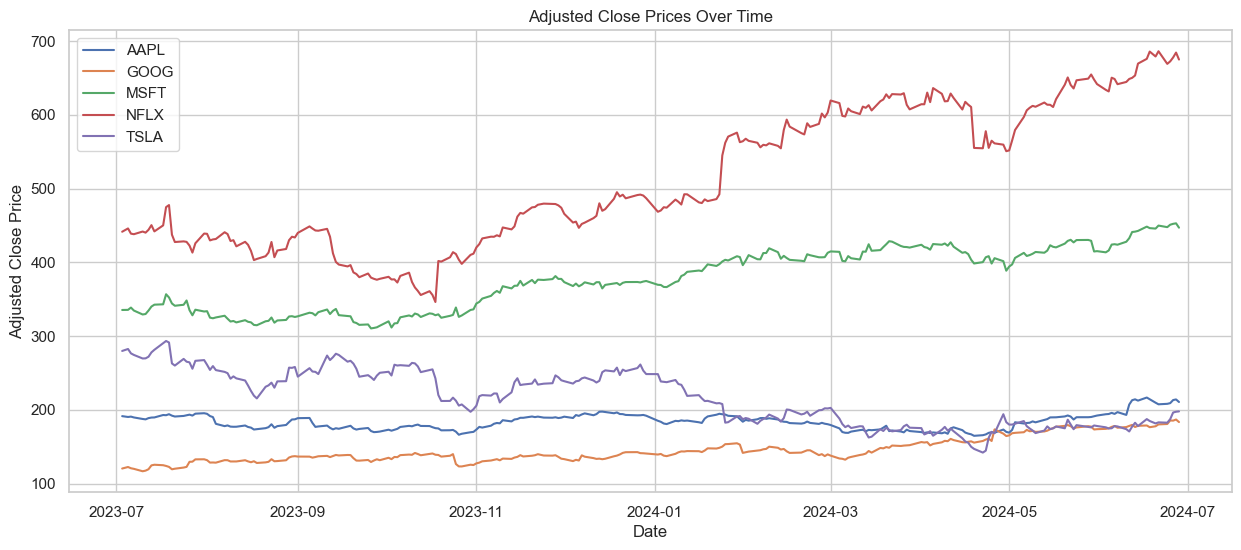

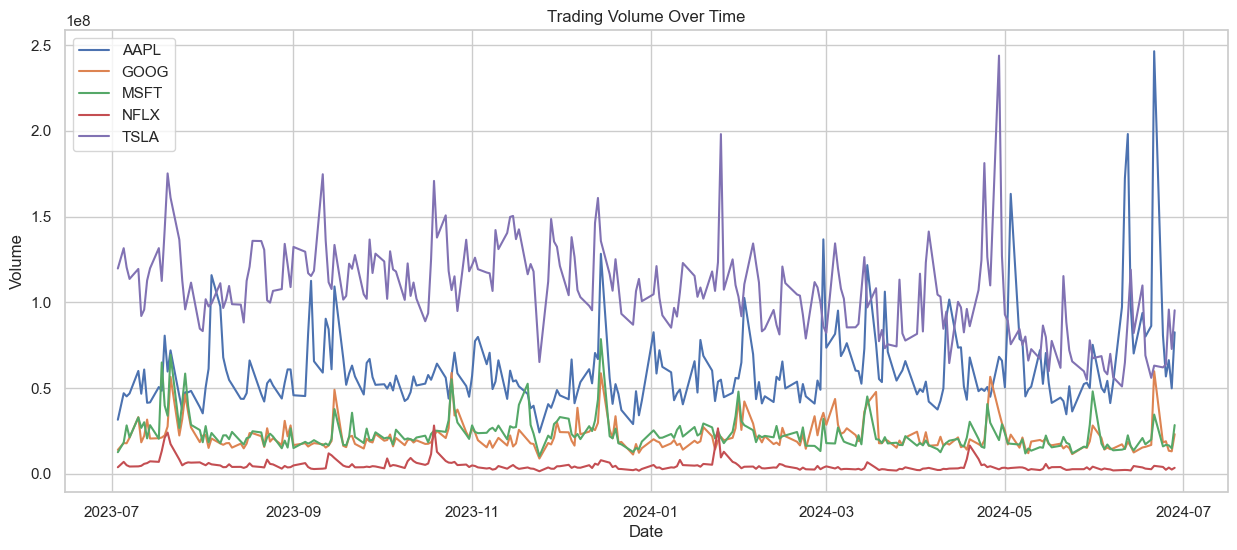

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [9]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-06-11   AAPL  207.149994  207.149994  207.160004  193.630005  193.649994   
2024-06-12   AAPL  213.070007  213.070007  220.199997  206.899994  207.369995   
2024-06-13   AAPL  214.240005  214.240005  216.750000  211.600006  214.740005   
2024-06-14   AAPL  212.490005  212.490005  215.169998  211.300003  213.850006   
2024-06-17   AAPL  216.669998  216.669998  218.949997  212.720001  213.369995   

Attribute        Volume   Z-score  
Date                               
2024-06-11  172373300.0  2.177532  
2024-06-12  198134300.0  2.725634  
2024-06-13   97862700.0  2.833958  
2024-06-14   70122700.0  2.671935  
2024-06-17   93728300.0  3.058937  


In [10]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-08-04   AAPL  181.028610  181.990005  187.380005  181.919998  185.520004   
2023-09-07   AAPL  176.860504  177.559998  178.210007  173.539993  175.179993   
2023-12-15   AAPL  197.050949  197.570007  198.399994  197.000000  197.529999   
2024-02-29   AAPL  180.505173  180.750000  182.570007  179.529999  181.270004   
2024-03-15   AAPL  172.386185  172.619995  172.619995  170.289993  171.169998   

Attribute        Volume   Z-score  
Date                               
2023-08-04  115799700.0  2.235860  
2023-09-07  112488800.0  2.102439  
2023-12-15  128256700.0  2.737846  
2024-02-29  136682600.0  3.077389  
2024-03-15  121664700.0  2.472205  


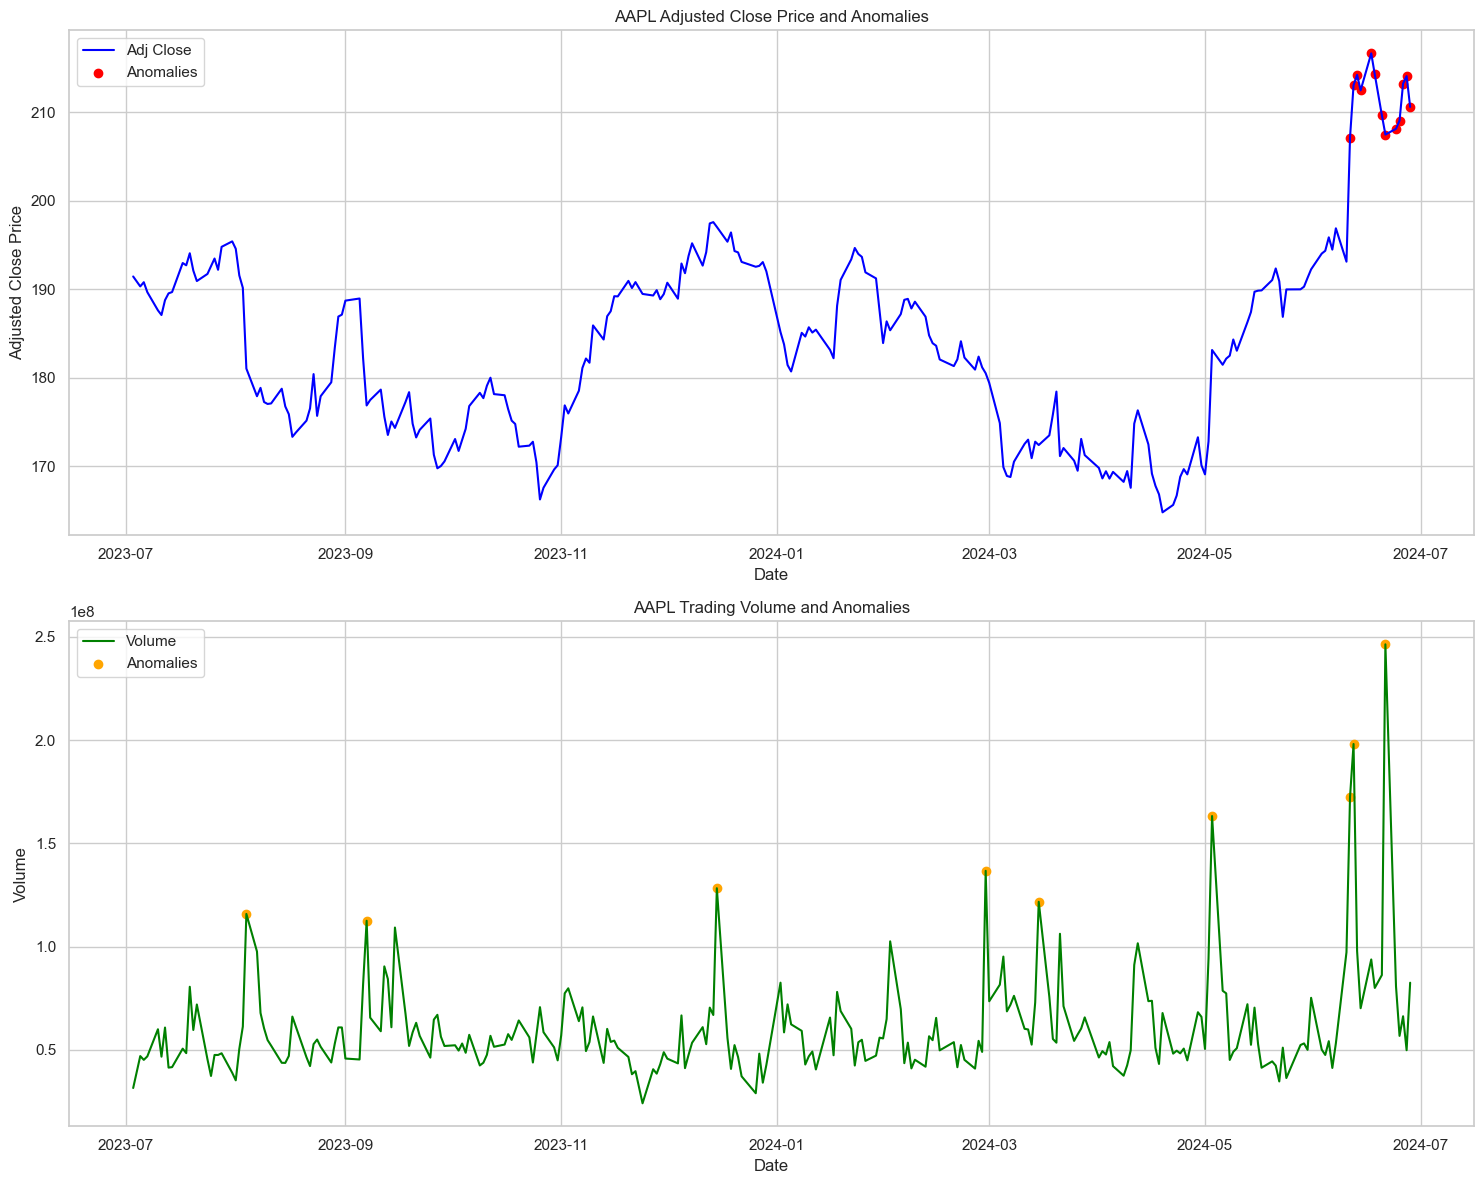

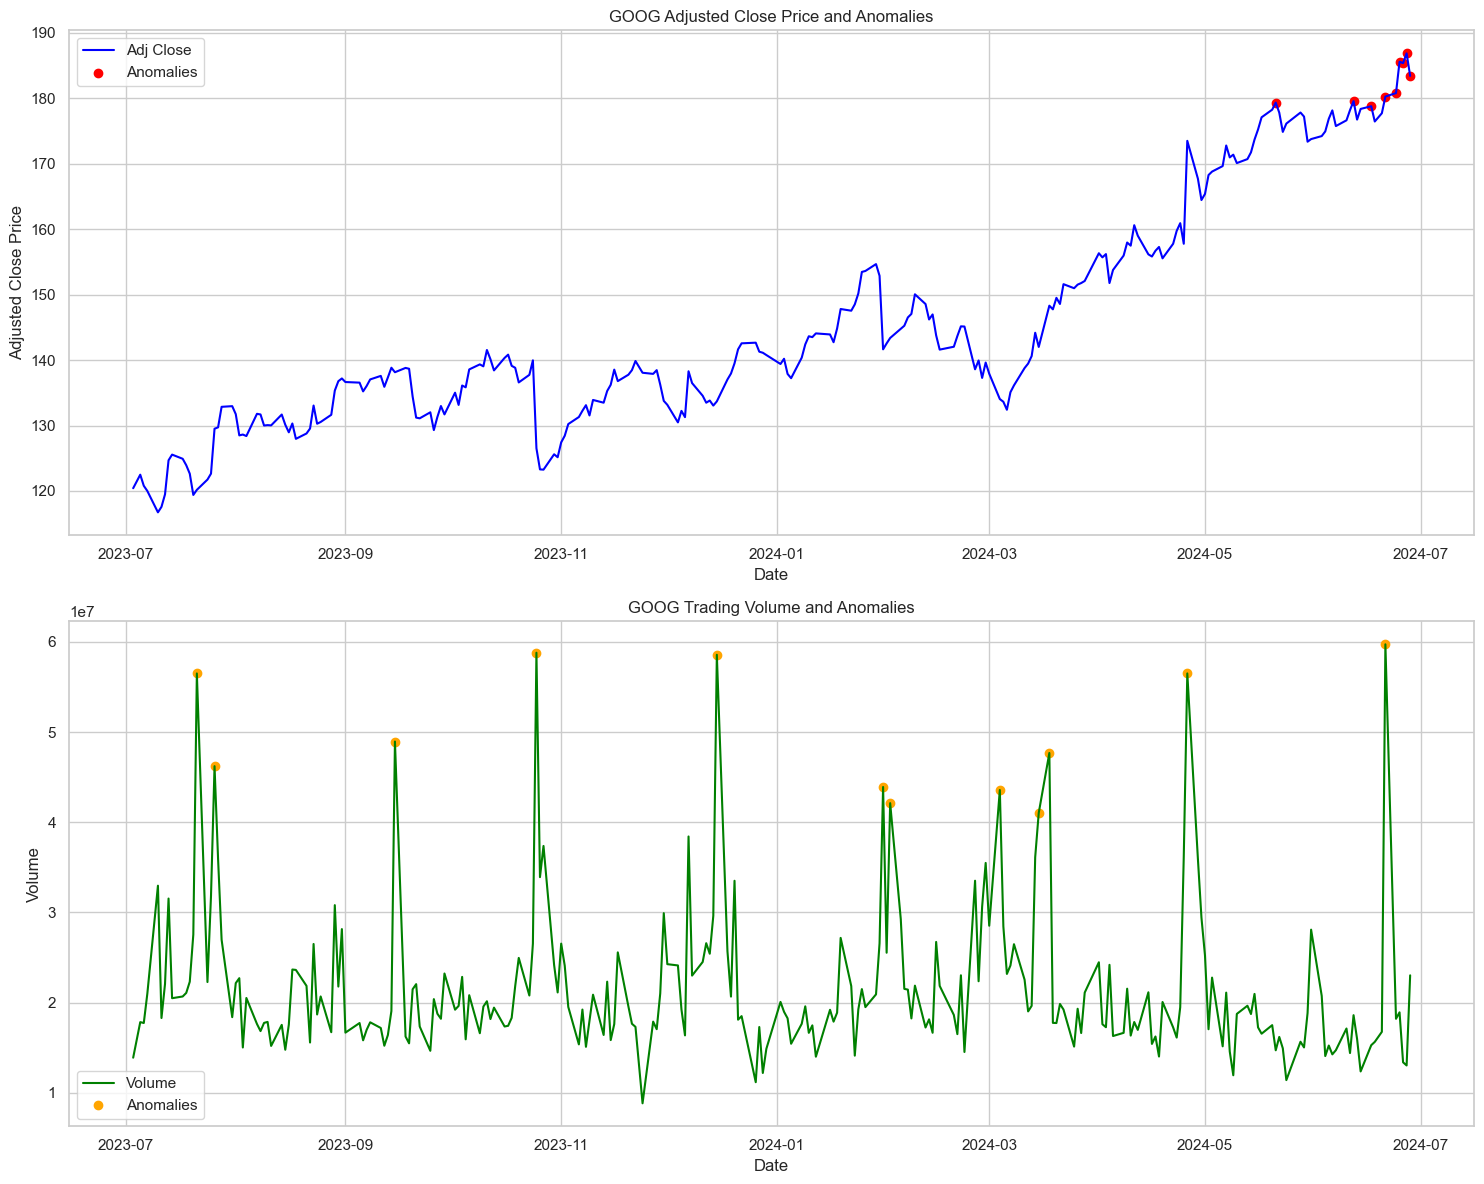

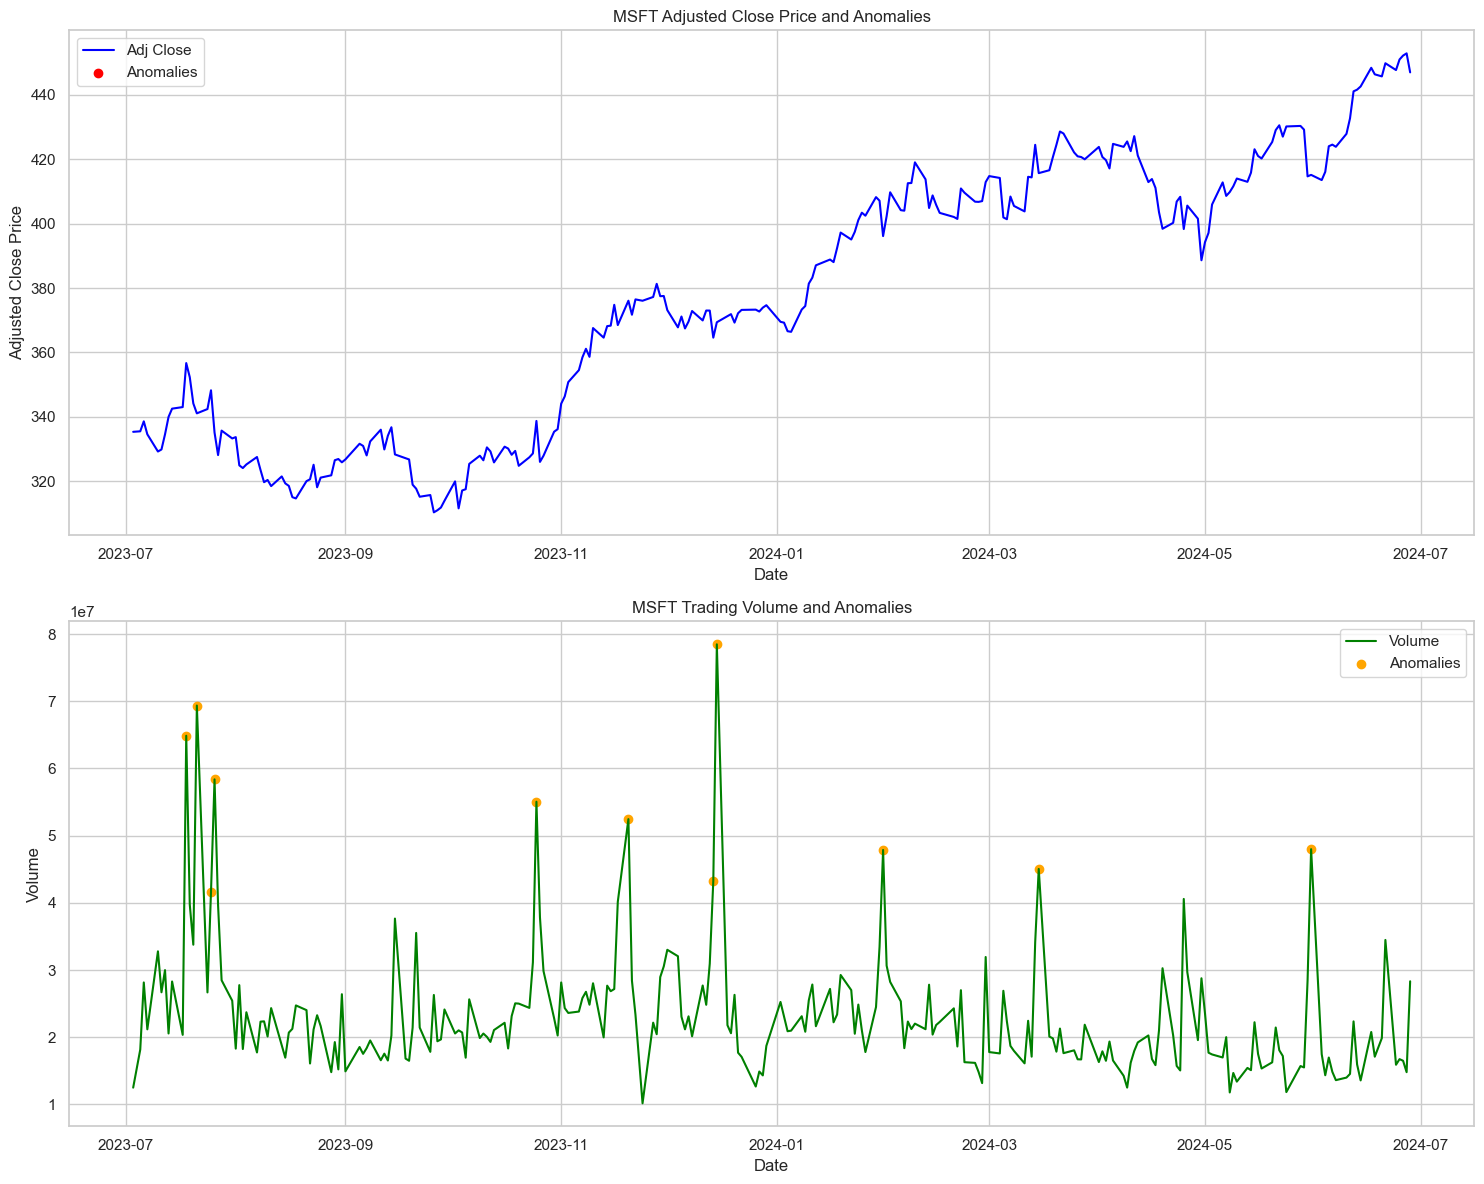

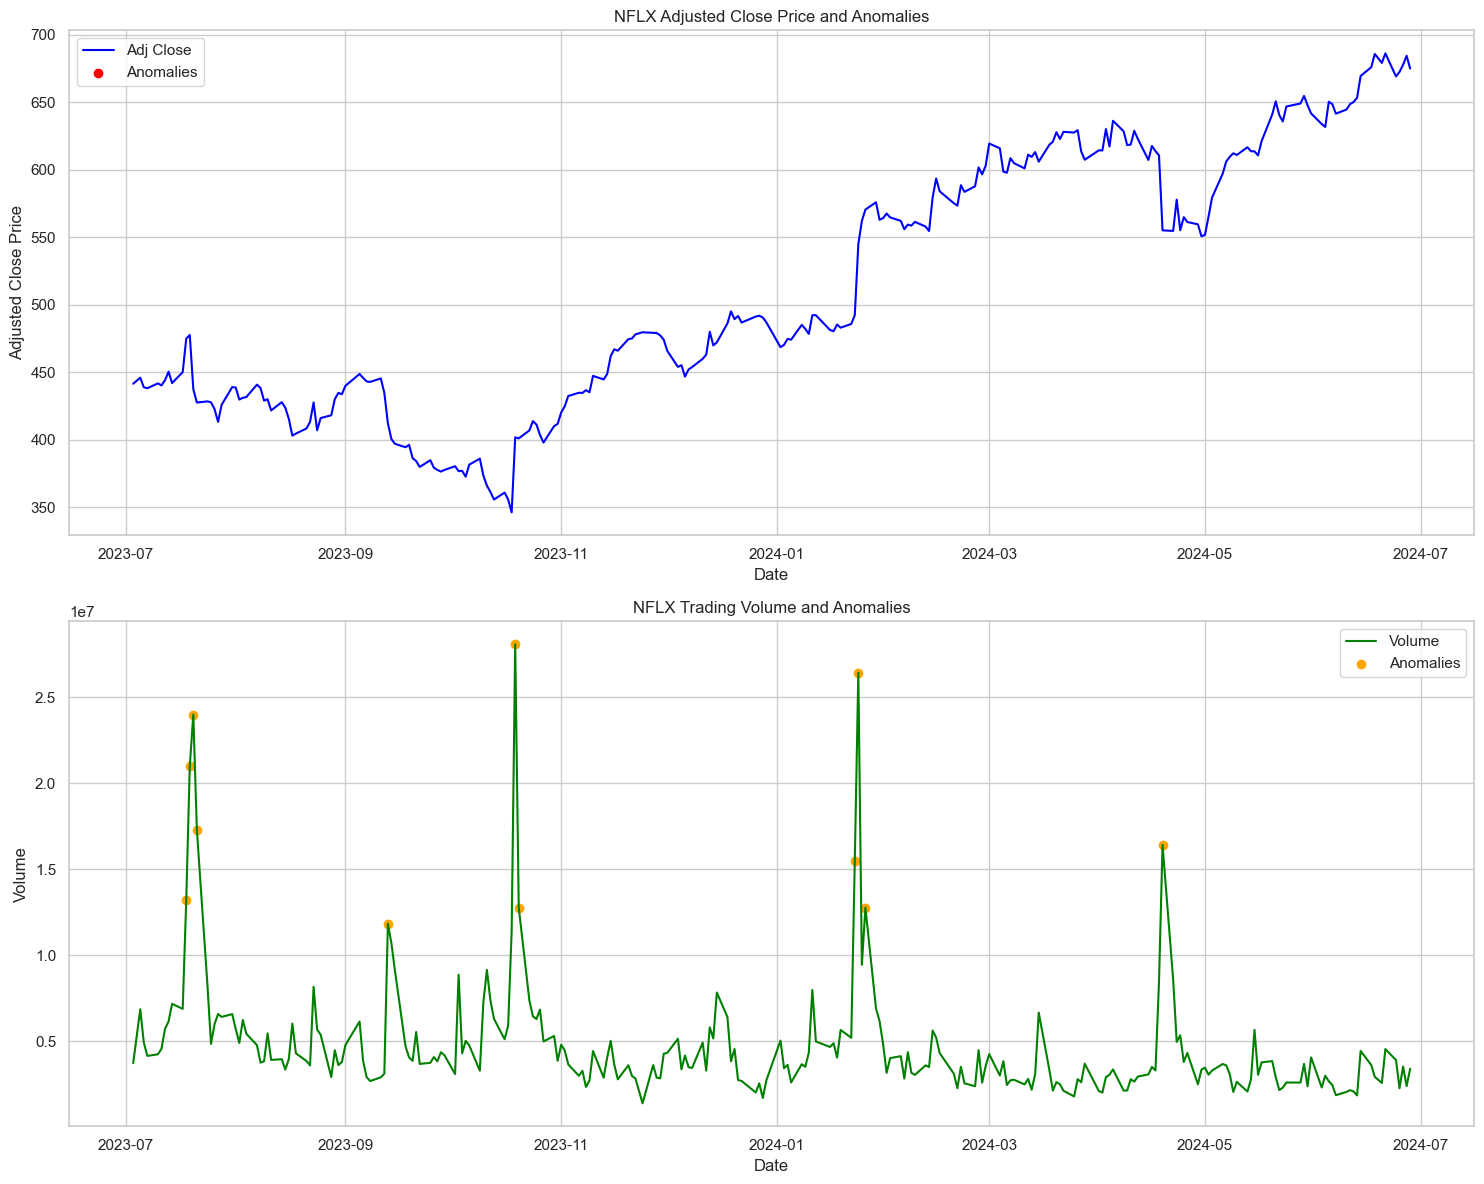

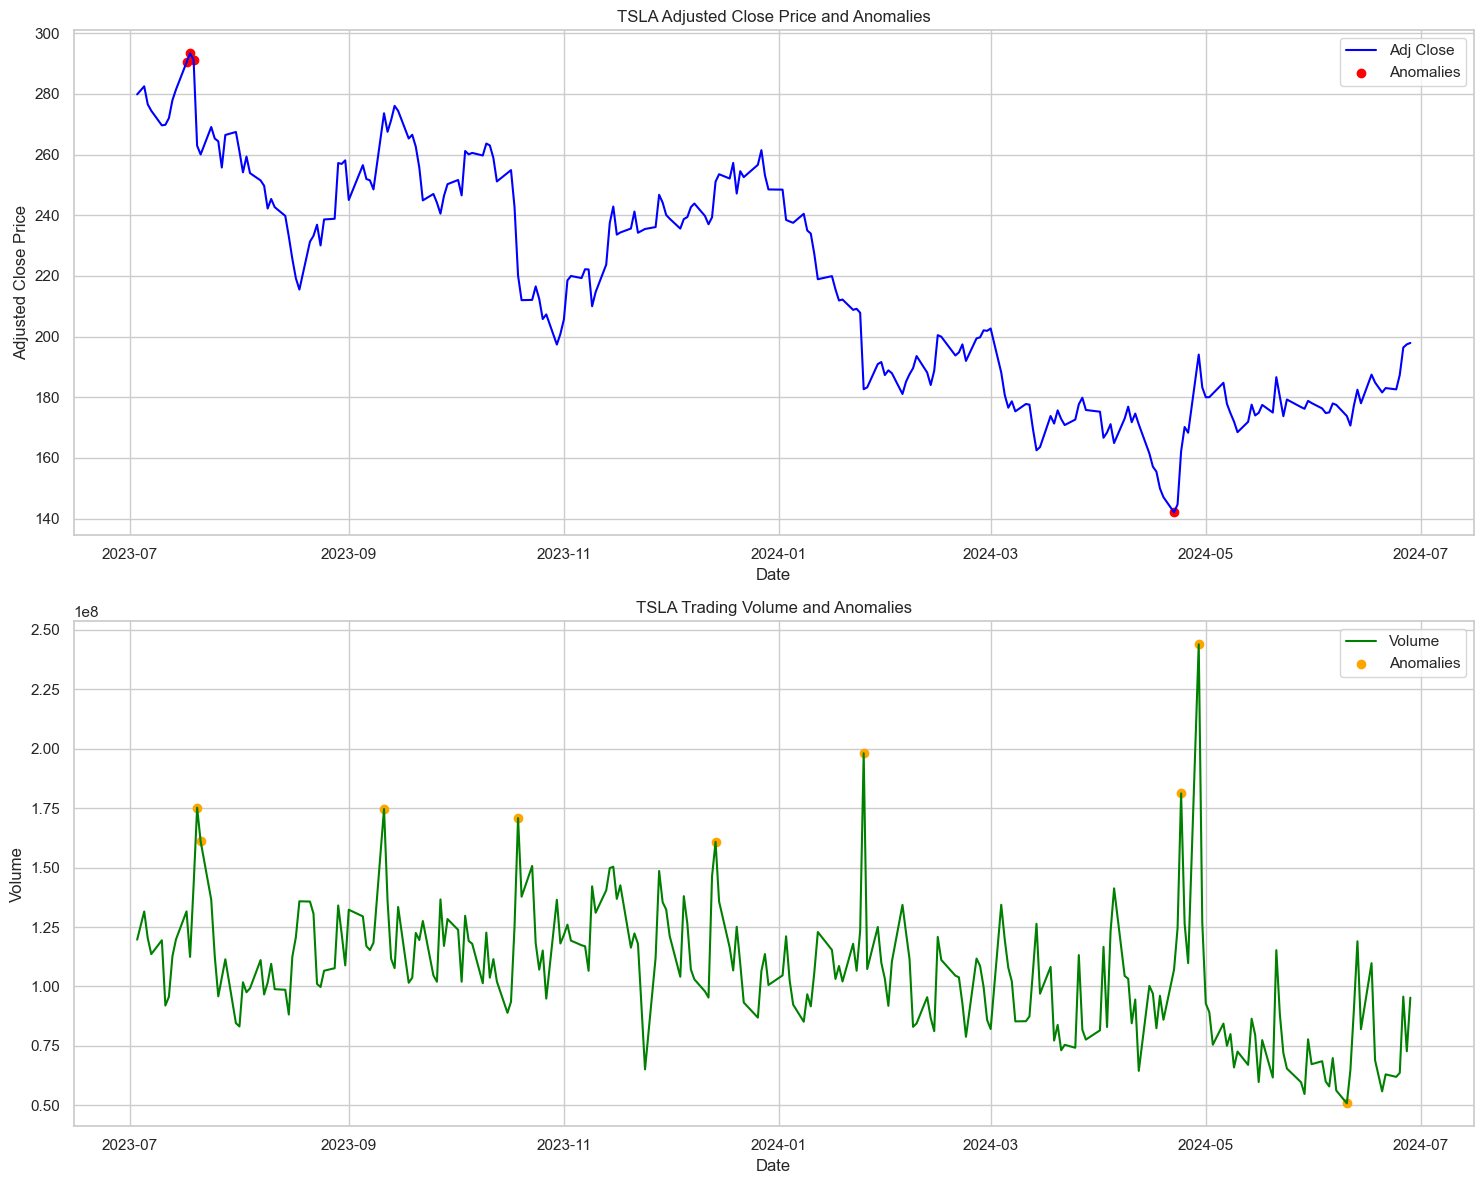

In [11]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [12]:
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly                     Volume Anomaly  \
Ticker                                AAPL      GOOG      TSLA           AAPL   
                  Ticker                                                        
Adj Close Anomaly AAPL            1.000000  0.372104 -0.861892       1.000000   
                  GOOG            0.372104  1.000000 -0.534522       0.666667   
                  TSLA           -0.861892 -0.534522  1.000000      -1.000000   
Volume Anomaly    AAPL            1.000000  0.666667 -1.000000       1.000000   
                  GOOG            0.408248  0.612372 -0.408248       0.010911   
                  MSFT           -0.612372 -0.408248  0.612372      -0.093123   
                  NFLX           -1.000000 -0.666667  1.000000      -0.368767   
                  TSLA                 NaN       NaN       NaN      -0.321429   

                                                                  
Ticker                        GOOG      M

In [13]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    1.000000
GOOG    0.501076
MSFT         NaN
NFLX         NaN
TSLA    0.000000
Name: Z-score, dtype: float64
